# Visualizing NRL list mode data
The NRL list mode for EXACT requires a bit of calibration to ensure that the relative detector time stamps are aligned with GPS time.

## How to: convert raw binary files into more useful data
1. Take data following the EXACT procedure in the docs
2. Copy the data files over to your computer using the `scp` command.
The files are named `hafx-nrl-listmode-*.bin.gz` where `*` has stuff like the date the file was created in it,
and which detector channel is being referenced.
3. Run the `decode-exact-science` executible on the data.
This executible is referenced like a script after you install the `umndet` Python package from this repository.
Here is an example of how to run it:
```bash
decode-exact-science --help
# Output:
# usage: decode-exact-science [-h] files [files ...] output_fn
# 
# Decode EXACT science files to JSON
# 
# positional arguments:
#   files       files to decode to JSON
#   output_fn   output file name to write JSON
# 
# options:
#   -h, --help  show this help message and exit

# Say your data files are in the following directory
cd data_files
# Run the script here and output to a compressed JSON
decode-exact-science hafx-nrl-listmode*.bin.gz decoded_exact.json.gz
```

The data file produced, `decoded_exact.json.gz`, is JSON data compressed using gzip.
The JSON is compressed because storing it as text takes up a lot of space.
Feel free to `gunzip` the file to see the space difference.

4. Once you have the file `decoded_exact.json`, you can open it and plot the data like in this Jupyter notebook
In this notebook, the data file is assumed to be called `exact_output.json.gz`.
The data used to generate this compressed JSON file is located on the SmallSat Google Drive [here](https://drive.google.com/drive/folders/1xrKwnJsnK9pJq4dPer7f0mL9BCXh9N3K).

In [22]:
import numpy as np
import json
import gzip
import matplotlib.pyplot as plt
import datetime

plt.style.use('style')
%matplotlib inline

In [23]:
fn = 'exact_output.json.gz'
with gzip.open(fn) as f:
    data = json.loads(f.read().decode('utf-8'))

In [24]:
# See what each data point has inside of it
data[0]

{'psd': 171,
 'energy': 3832,
 'external_trigger': 0,
 'piled_up': 1,
 'over_flow': 0,
 'out_of_range': 0,
 'was_pps': 0,
 'padding': 0,
 'absolute_timestamp': '2025-289-18-50-46_1324800'}

In [25]:
def timestamp_to_datetime(tstamp: str) -> datetime.datetime:
    '''Given the EXACT timestamp exported to the JSON file,
    parse the timestamp back into a datetime object'''
    datetime_str, ns_offset = tstamp.split('_')
    dtime = datetime.datetime.strptime(datetime_str, '%Y-%j-%H-%M-%S')
    delta = datetime.timedelta(microseconds=(int(ns_offset) / 1e3))
    return dtime + delta

In [26]:
# Most things we don't care about...for now
# Let's separate out the PPS events
energies = list()
times = list()

pps_indices = list()#[e['was_pps'] for e in data]
pps_times = list()
for (i, evt) in enumerate(data):
    if evt['was_pps']:
        pps_times.append(timestamp_to_datetime(evt['absolute_timestamp']))
        continue

    # We don't have a PPS event
    energies.append(evt['energy'])
    times.append(timestamp_to_datetime(evt['absolute_timestamp']))

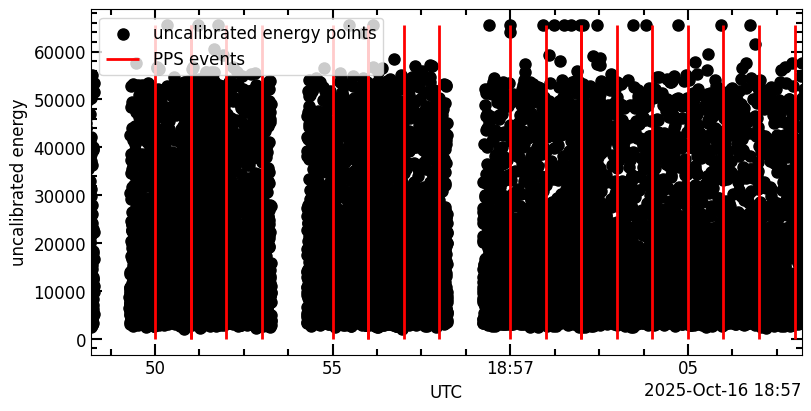

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.scatter(times, energies, color='black', label='uncalibrated energy points')
ax.vlines(pps_times, ymin=0, ymax=2**16, color='red', label='PPS events')
ax.legend(loc='upper left')
ax.set(
    xlabel='UTC',
    ylabel='uncalibrated energy',
    # Put the xlim right in the middle of the data
    xlim=(ta := times[len(times) // 2], ta + datetime.timedelta(seconds=20))
)
plt.show()